<div style=style="font-size: 16px">
   <center><strong>1η ΥΠΟΧΡΕΩΤΙΚΗ ΕΡΓΑΣΙΑ</strong></center>
</div>
<center>Κωνσταντής Αθανάσιος - ΑΕΜ: 10537</center>

Για την 1η Υποχρεωτική εργασία, μας ζητάται η υλοποίηση ενός <u><strong>νευρωνικού δικτύου εμπρόσθιας τροφοδότησης (feedforward NN)</strong></u>, είτε MLP είτε CNN, ή συνδιασμός των δυο, που θα εκπαιδεύεται με back-propagation. Το NN αυτό θα εκπαιδευτεί ώστε να λύνει προβλήματα κατηγοριοποιήσης και συγκεκριμένα, θα χρησιμοποιήσουμε το dataset cifar-10 που μας δώθηκε από την εκφώνηση της εργασίας, το οποίο αποτελείται από εικόνες που κατηγοριοποιούνται σε κλάσεις .

Έπειτα, θα δείξουμε μερικά παραδείγματα σωστής και λανθασμένης κατηγοριοποίησης, θα αναφέρουμε τον χρόνο εκτέλεσης της εκμάθησης του νευρωνικού και θα συγκρίνουμε τα αποτελέσματα με αυτά της ενδιάμεσης εργασίας μας.

Πρώτο μέλημα είναι η εισαγωγή των βιβλιοθηκών μας. Τις εισάγουμε από την αρχή ώστε να είναι πιο ξεκάθαρο ποιές βιβλιοθήκες χρησιμοποιούμε. Ο τρόπος χρήσης τους θα γίνει εμφανής στη συνέχεια.

In [2]:
import torch
from skimage.feature import hog
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import seaborn as sns
from torch.utils.data import TensorDataset
from sklearn.metrics import confusion_matrix
from torchinfo import summary
import pickle
from scipy.stats import mode

Έπειτα, θέλουμε ο κώδικάς μας να τρέχει στην GPU σε περίπτωση που η μηχανή μας έχει NVIDIA GPU που υποστηρίζει CUDA, αλλιώς στην CPU. Για λόγους πληρότητας, ας ξαναναφέρουμε σύντομα τα specs του υπολογιστή μας, κάτι που είναι απαραίτητο μιας και θα αναφέρουμε χρόνους εκτέλεσης κώδικα.

- Motherboard: ASRock B650M Pro RS Motherboard Micro ATX με AMD AM5 Socket
- RAM: Adata 32GB DDR5 RAM με Ταχύτητα 6400
- SSD: Western Digital SN770 SSD 2TB M.2 NVMe PCI Express 4.0
- CPU: AMD Ryzen 7 7800X3D 8-Core Processor 4.20 GHz
- GPU: NVIDIA GeForce GTX 1060 3GB

Γράφουμε τον παρακάτω κώδικα ώστε σε περίπτωση που υποστηρίζεται από το σύστημα, ο κώδικάς μας να τρέχει στην GPU.

In [3]:
# Set device type
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Την συνάρτηση unpickle την είδαμε στην ενδιάμεση εργασία, και μας δίνεται από την cifar-10 ώστε να μπορέσουμε να ανακτήσουμε τα δεδομένα από τη μορφή pickle στην οποία βρίσκονται.

In [4]:

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Το παρακάτω block κώδικα είναι μεγάλο και για αυτόν τον λόγο έχουμε εισάγει πλήρη σχόλια στον κώδικα. Γενικά, αποτελεί την φόρτωση του dataset στη μνήμη του υπολογιστή μας, σε διαφορετικές μορφές. Οι μορφές αυτές μας χρειάζονται παρακάτω και αποφασίσαμε να τις προετοιμάσουμε από την αρχή του κώδικα, ώστε να μην χρειαστεί να αλλάζουμε βασικές μεταβλητές που σχετίζονται με το dataset στο υπόλοιπο της εργασίας. Συγκεκριμένα, το dataset μας μπορεί να απεικονιστεί είτε σαν ένα σύνολο διανυσμάτων που περιέχουν τις τιμες RGB της εικόνας μας κατατεταγμένες η μια δίπλα στην άλλη ανά 1024 τιμές, είτε ως εικόνα 3x32x32 των τριών καναλιών RGB και του πίνακα 32x32 pixels για κάθε κανάλι. Επίσης, χωρίζουμε το dataset σε batches ώστε να μπορούμε να κάνουμε batch training στην πορεία.

In [6]:
BATCH_SIZE = 32
batches = []
for i in range(5):
    #add to the batches list, the arrays of each batch
    batches.append(unpickle(f"cifar-10-batches-py/data_batch_{i+1}"))
#stack the arrays vertically, resulting in a 50000x3072 matrix
train_data = np.vstack((batches[0][b'data'],batches[1][b'data'],batches[2][b'data'],batches[3][b'data'],batches[4][b'data']),dtype=np.uint8)
#stack the labels horizontally, resulting in a 1x50000 matrix
train_labels = np.hstack((batches[0][b'labels'],batches[1][b'labels'],batches[2][b'labels'],batches[3][b'labels'],batches[4][b'labels']),dtype=np.int64)
#prepare the test data in array form
test_batch = unpickle("cifar-10-batches-py/test_batch")
#numpy array of shape 10000x3072
test_data = test_batch[b'data']
#numpy array of shape 1x10000
test_labels = test_batch[b'labels']

#numpy array holding the whole dataset, shape 60000x3072
dataset = np.vstack((train_data,test_data))
#numpy array holding all the labels, shape 1x60000
labels = np.hstack((train_labels,test_labels))

#numpy array holding the whole dataset in image shape
dataset_img = dataset.reshape(60000,3,1024).reshape(60000,3,32,32)
#numpy array holding the training data in image shape
images_sep = train_data.reshape(50000,3,1024).reshape(50000,3,32,32)
#numpy array holding the testing data in image shape
images_sep_t = test_data.reshape(10000,3,1024).reshape(10000,3,32,32)

#Combination of all the data in image form for batch training
tr_data = TensorDataset(torch.from_numpy(images_sep).type(torch.float32).to(device),torch.from_numpy(train_labels).to(device))
te_data = TensorDataset(torch.from_numpy(images_sep_t).type(torch.float32).to(device),torch.tensor(test_labels).to(device))
train_dataloader_img = DataLoader(tr_data,batch_size=BATCH_SIZE,shuffle=False)
test_dataloader_img = DataLoader(te_data,batch_size=BATCH_SIZE,shuffle=False)

#Combination of all the data in vector form for batch training
tr_data = TensorDataset(torch.from_numpy(train_data).type(torch.float32).to(device),torch.from_numpy(train_labels).to(device))
te_data = TensorDataset(torch.from_numpy(test_data).type(torch.float32).to(device),torch.tensor(test_labels).to(device))
train_dataloader = DataLoader(tr_data, batch_size=BATCH_SIZE,shuffle=False)
test_dataloader = DataLoader(te_data,batch_size = BATCH_SIZE, shuffle=False)

train_data = torch.from_numpy(train_data).to(device).type(torch.float32)
test_data = torch.from_numpy(test_data).to(device).type(torch.float32)
test_labels = torch.Tensor(test_labels).to(device).type(torch.long)
train_labels = torch.from_numpy(train_labels).to(device).type(torch.long)

images_sep_t = torch.from_numpy(images_sep_t).to(device).type(torch.float32)
images_sep = torch.from_numpy(images_sep).to(device).type(torch.float32)

class_names = ['Class 0', 'Class 1', 'Class 2','Class 3','Class 4','Class 5','Class 6','Class 7','Class 8','Class 9']

Σημαντικό για τον κώδικά μας και το reproducability του είναι να χρησιμοποιήσουμε συγκεκριμένο seed για τις ψευδοτυχαίες συναρτήσεις μας.

In [7]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Μιας και το HOG διάγραμμα μας βοήθησε πολύ στην ενδιάμεση εργασία, δίνοντάς μας τα καλύτερα αποτελέσματα για τους αλγορίθμους KNN και Nearest Centroid, αποφασίσαμε να γράψουμε μια συνάρτηση που εξάγει τα HOG Features από τις φωτογραφίες, σε περίπτωση που θέλουμε να τα εισάγουμε σε κάποιο νευρωνικό. Εξάλλου, ο κώδικας ήταν ήδη έτοιμος από την προηγούμενη εργασία.

In [7]:
def extract_hog_features(train_data: np.array, test_data: np.array):
    hog_features = np.zeros((50000,324),np.float32)
    for index1,image in enumerate(train_data):
            hog_features[index1], hog_image = hog(image.transpose(1,2,0),pixels_per_cell=(8, 8),cells_per_block=(2, 2),visualize=True,channel_axis=-1,transform_sqrt=True)
    hog_features_t = np.zeros((10000,324),np.float32)
    for index1,image in enumerate(test_data):
        hog_features_t[index1], hog_image = hog(image.transpose(1,2,0),pixels_per_cell=(8, 8),cells_per_block=(2, 2),visualize=True,channel_axis=-1,transform_sqrt=True)
    return hog_features,hog_features_t


Παρακάτω παρουσιάζουμε 4 συναρτήσεις για το training και validation του μοντέλου. Οι μεταβλητές validation έχουν ονομαστεί test, παρ'όλα αυτά, αυστηρά θεωρητικά, το όνομά τους θα έπρεπε να λέγεται validation. Τα train και validation (test) steps έχουν γραφεί δύο φορές το καθένα ώστε να υποστηρίζουν τις διαδικασίες αυτές είτε με ένα tensor, είτε σε batches. Όπως φάνηκε αργότερα, η εκπαίδευση μοντέλων σε batches είναι κάτι που χρειαζόμαστε απαραίτητα ώστε η GPU μας να μην ξεμείνει από χώρο για πιο περίπλοκα μοντέλα. Συγκεκριμένα, επειδή η GPU μας έχει VRAM μόνο 3GB, υπήρχαν περιπτώσεις όπου ο αποθηκευτηκός χώρος τελείωνε και το πρόγραμμά μας μάς επέστρεφε error.

Είναι σημαντικό να υπογραμμιστεί ότι ακόμη και σε καλύτερες GPUs το training με batches πολλές φορές είναι αναγκαίο, μιας και αυξάνει την υπολογιστική αποδοτικότητα και μειώνει τον χρόνο εκπαίδευσης. Τα batches επίσης βοηθούν το μοντέλο να είναι καλύτερο στη γενίκευση. Όπως φαίνεται στον κώδικα παραπάνω, έχουμε ορίσει το BATCH_SIZE = 32. Γενικά, το νούμερο αυτό είναι σχετικά μικρό και λόγω αυτού μπορεί να επηρεάσει τον χρόνο εκπαίδευσης αρνητικά, αλλά επιλέγουμε αυτόν τον μικρό αριθμό ώστε να έχουμε μοντέλο αρκετά γενικευμένο. Σε κάθε περίπτωση, ο κώδικας είναι δομημένος έτσι ώστε το νούμερο αυτό να μπορεί να αλλάξει.

Παρακάτω δίνεται ο κώδικας training και validation για όλες τις περιπτώσεις. Ο κώδικας αυτός για τη βιβλιοθήκη της PyTorch είναι αρκετά τυποποιημένος και προσπαθήθηκε να ακολουθηθούν οι καλύτερες πρακτικές όσων αφορά την απόδοση και ταχύτητα του κώδικά μας. Για παράδειγμα, η χρήση inference_mode() στο evaluation step βοηθάει τον κώδικα να είναι πιο αποδοτικός επειδή δεν αποθηκεύει καθόλου πληροφορίες όσων αφορά τις παραγώγους των tensors που σχετίζονται με το συγκεκριμένο βήμα. Εδω λύνεται κιόλας με backward-propagation το πρόβλημα βελτιστοποίησης μέσω της μεθόδου `backward()`. Φυσικά, το πρόβλημα αυτό είναι σύνθετο στην υλοποίηση αλλά η δύναμη της PyTorch είναι ότι το έχει ήδη υλοποιήσει για εμάς. Για κάποιον που γνωρίζει τη βιβλιοθήκη, ο παρακάτω κώδικας θα πρέπει να είναι εύκολα κατανοητός.

NOTE: Σύμφωνα με το documentation της PyTorch είναι σημαντικό να καλέσουμε τη μέθοδο model.eval() πριν από οποιαδήποτε evaluation steps επειδή με αυτό τον τρόπο θέτουμε τα dropout και batch normalization layers σε evaluation mode. Θα εξηγήσουμε παρακάτω καλύτερα τι είναι αυτά τα layers, αλλά επειδή θα δουλέψουμε με Convolutional Neural Networks αργότερα, για να μην παίρνουμε inconsistent results, είναι σημαντικό να καλούμε την model.eval(). Το ίδιο βέβαια ισχύει και για την model.train() όταν θέλουμε να εκπαιδεύσουμε το μοντέλο. Συνεπώς, για να μην ξεχάσουμε, δημιουργήσαμε αυτές τις συναρτήσεις οι οποίες μπορούν να καλούνται για οποιοδήποτε μοντέλο.

In [8]:
def accuracy_score(y_pred,y_true):
    return (y_pred == y_true).sum().item()/len(y_pred)

def train_step_batch(model:nn.Module,train_dataloader: DataLoader,loss_fun:nn,optim:torch.optim,scheduler:torch.optim.lr_scheduler.ReduceLROnPlateau=None):
    train_loss = 0
    acc = 0
    for batch, (X,y) in enumerate(train_dataloader):
        model.train()
        y_logits = model(X)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)
        y_loss = loss_fun(y_logits,y)
        train_loss+=y_loss.item()
        acc += accuracy_score(y,y_preds)
        optim.zero_grad()

        y_loss.backward()

        optim.step()

    train_loss /= len(train_dataloader)
    acc /= len(train_dataloader)
    if(scheduler!=None):
            scheduler.step(train_loss)
    return train_loss, acc

def test_step_batch(model:nn.Module,test_dataloader: DataLoader, loss_fun: nn,return_preds:bool = False,return_all:bool = False):
    model.eval()
    test_loss = 0
    test_acc = 0
    predictions = []
    with torch.inference_mode():
        for indx,(X,y) in enumerate(test_dataloader):
            test_logits = model(X)
            test_loss += loss_fun(test_logits,y).item()
            pred_labels = torch.softmax(test_logits,dim=1).argmax(dim=1)
            test_acc += accuracy_score(y,pred_labels)
            if(return_preds or return_all):
                predictions.append(pred_labels.cpu().numpy())
        test_loss /= len(test_dataloader)
        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)
        if(return_preds):
             return np.concatenate(predictions).flatten()
        if(return_all): 
             return np.concatenate(predictions).flatten(),test_loss,test_acc
        return test_loss, test_acc

def train_step(model:nn.Module,train_data:torch.Tensor,train_labels:torch.Tensor,loss_fun:nn,optim:torch.optim,scheduler:torch.optim.lr_scheduler.ReduceLROnPlateau=None):
        model.train()
        acc = 0
        y_logits = model(train_data)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)
        train_loss = loss_fun(y_logits,train_labels)
        acc += accuracy_score(train_labels,y_preds)
        optim.zero_grad()
        train_loss.backward()
        optim.step()
        if(scheduler!=None):
            scheduler.step(train_loss)
        return train_loss,acc

def test_step(model:nn.Module,test_data:torch.Tensor,test_labels:torch.Tensor, loss_fun:nn,return_preds:bool = False,return_all:bool = False):
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        test_logits = model(test_data)
        test_loss = loss_fun(test_logits,test_labels).item()
        pred_labels = torch.softmax(test_logits,dim=1).argmax(dim=1)
        test_acc += accuracy_score(test_labels,pred_labels)
    if(return_preds):
        return pred_labels.cpu().numpy()
    if(return_all):
         return pred_labels.cpu().numpy(), test_loss, test_acc
    return test_loss, test_acc

Παρακάτω παρουσιάζουμε επίσης την συνάρτηση για το plotting του confusion matrix. Το confusion matrix είναι ενας πίνακας ο οποίος μας δείχνει τις πραγματικές κλάσεις μας, και το ποσοστό επιτυχίας του μοντέλου για καθεμία από αυτές. Αντίστοιχα, παίρνουμε πληροφορία και για το ποσοστό λανθασμένης εκτίμησης για κάθε κλάση η οποία δεν είναι η πραγματική. Αυτές οι πληροφορίες είναι σημαντικές, επειδή μας δίνουν μια εικονική αναπαράσταση της αξιοπιστίας του μοντέλου, καθώς και μας επιτρέπει να δούμε εύκολα αν το μοντέλο μπερδεύει συγκεκριμένες κλάσεις μεταξύ τους περισσότερο από άλλες. Με αυτόν τον τρόπο, μπορούμε να κάνουμε απαραίτητες αλλαγές στην εκπαίδευσή του για να πετύχουμε ένα αποδεκτό και ισορροπημένο αποτέλεσμα.

In [9]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    if isinstance(true_labels, torch.Tensor):
        true_labels = true_labels.cpu().numpy()
    if isinstance(predicted_labels, torch.Tensor):
        predicted_labels = predicted_labels.cpu().numpy()

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

Γράφουμε σε κώδικα επίσης συναρτήσεις που μας αφήνουν να αποθηκεύσουμε εύκολα τις πληροφορίες ενός μοντέλου, καθώς και να τις ανακτήσουμε. Αυτές οι συναρτήσεις γενικά γράφηκαν ώστε να κάνουν τον κώδικά μας πιο ευανάγνωστο και να βοηθήσουν τη ροή της διαδικασίας συγγραφής κώδικα. Προσπαθούμε να έχουμε μικρά κομμάτια κώδικα χωρίς μεγάλη πολυπλοκότητα στην κατανόηση, μιας και αυτό είναι καλή πρακτική και η Python είναι πολύ ισχυρή στο συγκεκριμένο ζήτημα. Επιλέξαμε να σώσουμε στη μνήμη το state_dict του μοντέλου, δηλαδή το λεξικό που περιέχει όλες τις πληροφορίες για τα βάρη,biases του μοντέλου μας. Με αυτόν τον τρόπο, αν δημιουργήσουμε ενα instance της ίδιας κλάσης και φορτώσουμε σε αυτή το state dict, στην πραγματικότητα καταλήγουμε με το ίδιο μοντέλο. Σύμφωνα με το documentation, αυτός είναι ο ιδανικός τρόπος να σωθεί ένα μοντέλο στη μνήμη μιας και το state dict αρκεί για ένα μοντέλο ώστε να το χαρακτηρίσει πλήρως.

Η torch.save() χρησιμοποιή το Pickle utility της Python για να αποθηκεύσει στη μνήμη μοντέλα, tensors και dictionaries και η torch.load() το ίδιο για να τα φορτώσει από τη μνήμη.

In [19]:

def save_model_info(model:nn.Module,filename):
    p = Path(f"{filename}.pt")
    torch.save(model.state_dict(),p)

def load_model_info(model,filename):
    if not isinstance(filename,Path):
        p = Path(filename)
        if(p.exists()):
            model.load_state_dict(torch.load(p))
        else:
            print(f"{filename} doesn't exist")
    else:
        model.load_state_dict(torch.load(filename,map_location=device))
    return model

Ήρθε η ωρα να γράψουμε κώδικα για το πρώτο μας Νευρωνικό Δίκτυο. Κάθε κλάση που γράφουμε, σύμφωνα με την PyTorch θα πρέπει να κάνει inherit από την κλάση nn.Module. Έπειτα, δημιουργούμε έναν sequential container, ο οποίος μας βοηθά να φτιάξουμε ένα feedforward NN. Ουσιαστικά, κατατάσσει στη σειρά που του δίνουμε τα διαφορετικά layers του νευρωνικού και τα συνδέει το ένα με το άλλο σειριακά, επιστρέφοντας τελικά το output του τελευταίου layer. Για το πρώτο μας νευρωνικό, θα ξεκινήσουμε δημιουργώντας ένα απλό δίκτυο ενός μόνο hidden layer για να δούμε πώς αποδίδει με τα δεδομένα μας. Προφανώς, το μέγεθος του διανύσματος εισόδου είναι 3072 (3x32x32) και το διάνυσμα εξόδου έχει 10 διαστάσεις, που περιέχουν την πιθανότητα για καθεμία από τις 10 κλάσεις. Παρακάτω δίνεται ο κώδικας.

In [10]:
class Model0MLP(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fwd_layer = nn.Sequential(
            nn.Linear(in_features=3072,out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500,out_features=10)
        )
    def forward(self,x:torch.Tensor):
        return self.fwd_layer(x)

Δημιουργούμε ένα instance του μοντέλου μας, και επιλέγουμε loss function και optimizer. Για προβλήματα κατηγοριοποίησης πολλαπλών κλάσεων (πάνω από δύο), χρησιμοποιούμε loss function την CrossEntropyLoss. Επειδή το training set μας είναι balanced, δεν χρειάζεται να εισάγουμε ως input κάποια βάρη. Η CrossEntropyLoss περιμένει ως input την μη-κανονικοποιημένη έξοδο του νευρωνικού μας (logits). Ο λόγος που συμβαίνει αυτό, είναι επειδή η συνάρτηση softmax μπορεί κάποιες φορές να οδηγήσει σε αριθμητική αστάθεια. Η CrossEntropyLoss έχει γραφεί ώστε να χρησιμοποιεί το "log sum exp" τρικ που αποφεύγει τέτοιες περιπτώσεις.

Το "log sum exp" τρικ είναι μια τεχνική αριθμητικής σταθεροποίησης που χρησιμοποιείται για τον υπολογισμό του λογαρίθμου ενός αθροίσματος από exponentials. Επειδή το άθροισμα των εκθετικών μπορεί να βγει πολύ μεγάλο, και αρα να καταλήξει σε overflow ή αντίστοιχα πολύ μικρό, αρα να οδηγήσει σε underflow, οπότε μετά όταν λογαριθμίζουμε το αποτέλεσμά μας μπορεί να είναι λανθασμένο, μπορούμε να κάνουμε τo παρακάτω:$$\log{\left(\sum_i e^{x_i}\right)} = m + \log{\left(\sum_i{e^{x_i-m}}\right)}$$
όπου $m = max(x_i)\newline$
Έτσι, ξέρουμε ότι οι εκθέτες των exponentials είναι πάντα μικρότεροι του μηδενός και άρα αποφεύγεται η αριθμητική αστάθεια.



Για optimizer έχουμε δύο επιλογές, είτε τη χρήση του Stochastic Gradient Descent, είτε τη χρήση του αλγόριθμου Adam. Αυτοί οι δυο optimizers δουλεύουν βέλτιστα για προβλήματα classification. Επειδή είναι αρκετά standard, θα χρησιμοποιήσουμε SGD για αρχή και αργότερα θα πειραματιστούμε με τον Adam. Ο αλγόριθμος Stochastic Gradient Descent είναι ίδιος με το Gradient Descent, όπου χρησιμοποιείται η αντίθετη κατεύθυνση της παραγώγου της συνάρτησης κόστους ώστε να μειώνουμε σε κάθε βήμα το σφάλμα μας. Όμως, ο αλγόριθμος αυτός είναι επιρρεπής στο να συγκλίνει σε τοπικά ελάχιστα αντί για ολικά, κάτι που η SGD λύνει καλύτερα με την εισαγωγή θορύβου.

<img src="Screenshot 2024-11-23 033943.png" width=400px height=400px />

Παράδειγμα της μεθόδου Gradient Descent από εργασία μας στο μάθημα Τεχνικές Βελτιστοποίησης. Παρατηρούμε τη σύγκλιση στο ελάχιστο σταδιακά, με τη χρήση του κανόνα Armijo. Για πληρότητα γράφουμε παρακάτω τον αναδρομικό τύπο της SGD: $$ x_{k+1} = x_k - \gamma \nabla f(x_k) - \eta e_k $$

Οι παράμετροι learning rate και momentum επιλέγονται πειραματικά στις τιμές που τους δώσαμε.

In [12]:
def train_and_test_model(model:nn.Module,train_data:torch.Tensor,train_labels:torch.Tensor,test_data:torch.Tensor,test_labels:torch.Tensor,loss_fun:nn,optimizer:torch.optim,scheduler:torch.optim.lr_scheduler.ReduceLROnPlateau = None,epochs:int = 100):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    test_accuracies = np.zeros(epochs)
    train_accuracies = np.zeros(epochs)
    for epoch in range(epochs):
        train_losses[epoch],train_accuracies[epoch] = train_step(model,train_data,train_labels,loss_fun,optimizer,scheduler)
        test_losses[epoch],test_accuracies[epoch] = test_step(model,test_data,test_labels,loss_fun)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"epoch {epoch} \ttrain loss: {train_losses[epoch]:.5f} \ttest loss: {test_losses[epoch]:.5f} \ttrain_acc = {train_accuracies[epoch]*100:.2f}\ttest_acc = {test_accuracies[epoch]*100:.2f} \tlr={current_lr}")
    return train_losses, test_losses, test_accuracies, train_accuracies

def train_and_test_model_batch(model:nn.Module,train_dataloader:DataLoader,test_dataloader:DataLoader,loss_fun:nn,optimizer:torch.optim,scheduler:torch.optim.lr_scheduler.ReduceLROnPlateau = None,epochs:int = 100):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    test_accuracies = np.zeros(epochs)
    train_accuracies = np.zeros(epochs)
    for epoch in range(epochs):
        train_losses[epoch],train_accuracies[epoch] = train_step_batch(model,train_dataloader,loss_fun,optimizer,scheduler)
        test_losses[epoch],test_accuracies[epoch] = test_step_batch(model,test_dataloader,loss_fun)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"epoch {epoch} \ttrain loss: {train_losses[epoch]:.5f} \ttest loss: {test_losses[epoch]:.5f} \ttrain_acc = {train_accuracies[epoch]*100:.2f}\ttest_acc = {test_accuracies[epoch]*100:.2f} \tlr={current_lr}")
    return train_losses, test_losses, test_accuracies, train_accuracies

def plot_graphs(train_loss:np.array,test_loss:np.array,train_acc:np.array,test_acc:np.array):
    lin = np.linspace(0,1,len(train_acc))

    axis1 = plt.subplot(211)
    axis2 = plt.subplot(212)
    axis1.plot(lin,train_loss,color='red',label = 'Train loss')
    axis1.plot(lin,test_loss,color='blue',label="Test loss")
    axis1.set_xlabel('epochs')
    axis1.set_ylabel('loss')
    axis1.set_title('Train and test loss per epoch')
    axis1.legend()
    axis1.grid(True)
    
    axis2.plot(lin,train_acc,color='red',label = 'Train accuracy')
    axis2.plot(lin,test_acc,color='blue',label="Test accuracy")
    axis2.set_xlabel('epochs')
    axis2.set_ylabel('accuracy')
    axis2.set_title('Train and test accuracy per epoch')
    axis2.legend()
    axis2.grid(True)
    
    plt.tight_layout()
    plt.show()

Έχουμε γράψει παραπάνω κώδικα ο οποίος μας επιτρέπει να εκπαιδεύσουμε και να αναπαραστήσουμε τα αποτελέσματα του μοντέλου μας με μεγάλη ευκολία. Χρησιμοποιώντας τις συναρτήσεις μας, έχουμε:

epoch 0 	train loss: 56.12713 	test loss: 59696.55078 	train_acc = 10.15	test_acc = 10.00 	lr=0.01
epoch 1 	train loss: 59026.24219 	test loss: 1753702.37500 	train_acc = 10.00	test_acc = 10.00 	lr=0.01
epoch 2 	train loss: 1718269.37500 	test loss: 126020.28906 	train_acc = 10.00	test_acc = 10.00 	lr=0.01
epoch 3 	train loss: 125786.25781 	test loss: 7933.90723 	train_acc = 10.00	test_acc = 10.00 	lr=0.01
epoch 4 	train loss: 7784.23438 	test loss: 2.30745 	train_acc = 10.00	test_acc = 9.92 	lr=0.01
epoch 5 	train loss: 2.30833 	test loss: 2.30517 	train_acc = 9.99	test_acc = 10.04 	lr=0.01
epoch 6 	train loss: 2.30497 	test loss: 2.30483 	train_acc = 10.04	test_acc = 10.02 	lr=0.01
epoch 7 	train loss: 2.30444 	test loss: 2.30461 	train_acc = 10.06	test_acc = 10.05 	lr=0.01
epoch 8 	train loss: 2.30414 	test loss: 2.30445 	train_acc = 10.07	test_acc = 10.03 	lr=0.01
epoch 9 	train loss: 2.30389 	test loss: 2.30432 	train_acc = 10.07	test_acc = 10.03 	lr=0.01
epoch 10 	train loss: 2.3

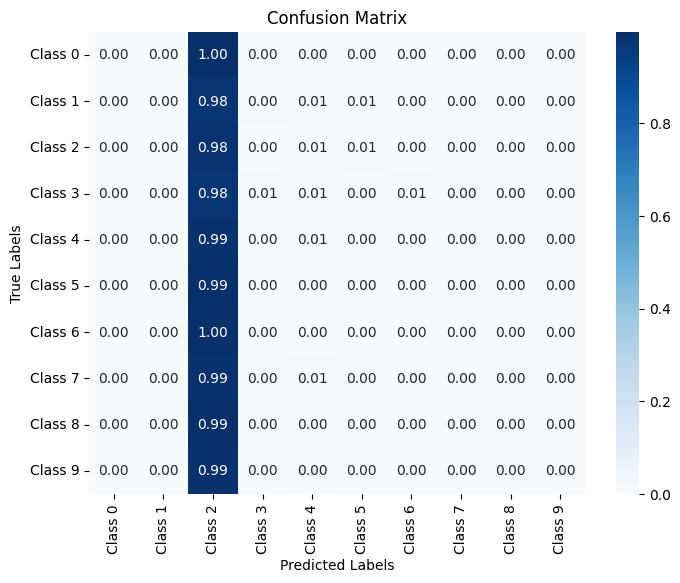

In [16]:

model0 = Model0MLP().to(device)
loss_fun = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model0.parameters(),lr = 0.01,momentum=0.2)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model(model0,train_data,train_labels,test_data,test_labels,loss_fun,optim)
pred_labels = test_step(model0,test_data,test_labels,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels, pred_labels, class_names)

Παρατηρούμε ότι το validation μας δίνει 10% accuracy, που είναι απλά το accuracy που θα πετυχαίναμε αν επιλέγαμε τυχαία μια κλάση για κάθε εικόνα. Συνεπώς, το μοντέλο αυτό δεν μαθαίνει.
Απ'οτι βλέπουμε, τα predictions του μας δίνουν αποτέλεσμα μόνο την κλάση 2.

Γενικά, μπορούν να γίνουν αλλαγές στις παραμέτρους για να πάρουμε ίσως λίγο καλύτερο αποτέλεσμα, αλλά δεν θα ασχοληθούμε παραπάνω με το συγκεκριμένο μοντέλο μιας και είναι αρκετά αδύναμο. Θα κάνουμε μια προσπάθεια να λύσουμε το πρόβλημα με ένα MLP fully connected με 3 hidden layers.

In [12]:
class Model1MLP(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fwd_layer = nn.Sequential(
            nn.Linear(in_features=3072,out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100,out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100,out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100,out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100,out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100,out_features=10)
        )
    def forward(self,x:torch.Tensor):
        return self.fwd_layer(x)

Επιλέγουμε στο μοντέλο αυτό να εισάγουμε εναν scheduler. Οι schedulers είναι εργαλεία που μειώνουν το learning rate, δηλαδή στην ουσία μειώνουν το βήμα της Gradient Descent δυναμικά, ώστε να συγκλίνουμε πιο κοντά στο ελάχιστο. Γενικά η ιδέα είναι να ξεκινάμε με μεγαλύτερο learning rate και σιγά σιγά αυτό να μειώνεται. Υπάρχουν γενικά διάφοροι schedulers αλλά εμείς επιλέξαμε τον ReduceLROnPlateau, ο οποίος μειώνει το learning rate αν δεν έχει βελτιωθεί το train error τις προηγούμενες `patience` επαναλήψεις. Το `patience` το θέσαμε 10, και το `factor`, που ορίζει κατά πόσο μειώνεται το learning rate το θέσαμε 0.1.

epoch 0 	train loss: 2.51916 	test loss: 10.33794 	train_acc = 9.71	test_acc = 9.99 	lr=0.1
epoch 1 	train loss: 10.28874 	test loss: 11385.01562 	train_acc = 9.97	test_acc = 10.00 	lr=0.1
epoch 2 	train loss: 11275.77637 	test loss: 649668853760.00000 	train_acc = 10.00	test_acc = 10.00 	lr=0.1
epoch 3 	train loss: 642413035520.00000 	test loss: nan 	train_acc = 10.00	test_acc = 10.00 	lr=0.1
epoch 4 	train loss: nan 	test loss: nan 	train_acc = 10.00	test_acc = 10.00 	lr=0.1
epoch 5 	train loss: nan 	test loss: nan 	train_acc = 10.00	test_acc = 10.00 	lr=0.1
epoch 6 	train loss: nan 	test loss: nan 	train_acc = 10.00	test_acc = 10.00 	lr=0.1
epoch 7 	train loss: nan 	test loss: nan 	train_acc = 10.00	test_acc = 10.00 	lr=0.1
epoch 8 	train loss: nan 	test loss: nan 	train_acc = 10.00	test_acc = 10.00 	lr=0.1
epoch 9 	train loss: nan 	test loss: nan 	train_acc = 10.00	test_acc = 10.00 	lr=0.1
epoch 10 	train loss: nan 	test loss: nan 	train_acc = 10.00	test_acc = 10.00 	lr=0.1
epoch 1

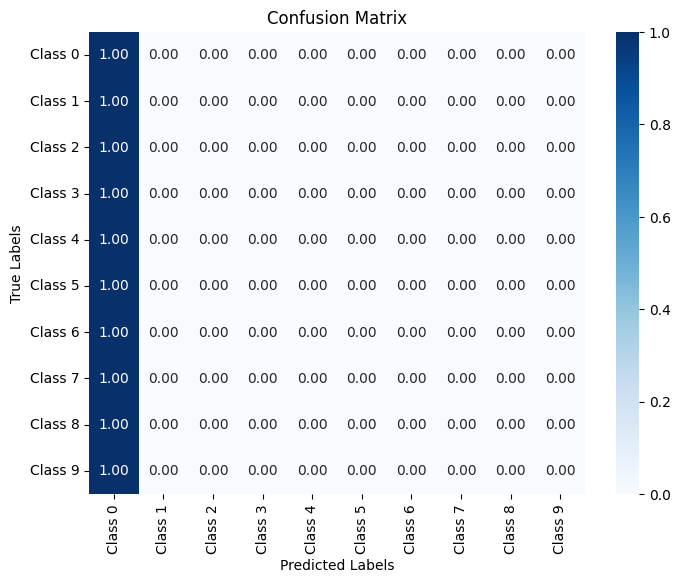

In [18]:
model1 = Model1MLP().to(device)
loss_fun = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model1.parameters(),lr = 0.1,momentum=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,mode='min',factor=0.1,patience=10)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model(model1,train_data,train_labels,test_data,test_labels,loss_fun,optim,scheduler,epochs=100)
pred_labels = test_step(model1,test_data,test_labels,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels, pred_labels, class_names)

Το σφάλμα αυξάνει πάρα πολύ γρήγορα, και φτάνουμε σε NaN αμέσως, κάτι που δεν επιτρέπει την συνέχιση της εκπαίδευσης. Είναι σημαντικό το αποτέλεσμα αυτό. Όταν τα βάρη ενός MLP αυξάνονται πολύ, στα επόμενα layers έχουμε εκθετική αύξηση των βαρών αυτών, οδηγώντας μας σε αστάθεια. Το πρόβλημα αυτό λέγεται Exploding Gradients. Αντίστοιχα θα μπορούσαμε να είχαμε το πρόβλημα των Vanishing Gradients, δηλαδή τα πολύ μικρά βάρη μπορεί να μειώνουν τόσο πολύ τις παραγώγους και έτσι η εκπαίδευση να σταματάει ή να καθίσταται πολύ αργή. Το υψηλό μας learning rate παίζει καθοριστικό ρόλο στο γεγονός ότι έχουμε τόσο γρήγορη απόκλιση. Γενικά, υψηλό learning rate σε συνδιασμό με την ReLU activation function εχει παρατηρηθεί ότι δίνει πολύ φτωχά αποτελέσματα. Παρατηρούμε παρακάτω ότι αν μειώσουμε το learning rate, το πρόβλημα της απόκλισης λύνεται.

epoch 0 	train loss: 2.65207 	test loss: 2.60071 	train_acc = 9.96	test_acc = 10.00 	lr=0.005
epoch 1 	train loss: 2.59802 	test loss: 2.37222 	train_acc = 9.99	test_acc = 12.06 	lr=0.005
epoch 2 	train loss: 2.37453 	test loss: 2.31768 	train_acc = 11.80	test_acc = 11.47 	lr=0.005
epoch 3 	train loss: 2.31828 	test loss: 2.29824 	train_acc = 11.09	test_acc = 12.11 	lr=0.005
epoch 4 	train loss: 2.29890 	test loss: 2.28733 	train_acc = 11.84	test_acc = 12.81 	lr=0.005
epoch 5 	train loss: 2.28813 	test loss: 2.27881 	train_acc = 12.94	test_acc = 13.20 	lr=0.005
epoch 6 	train loss: 2.27950 	test loss: 2.27157 	train_acc = 13.57	test_acc = 14.27 	lr=0.005
epoch 7 	train loss: 2.27225 	test loss: 2.26476 	train_acc = 14.29	test_acc = 14.17 	lr=0.005
epoch 8 	train loss: 2.26558 	test loss: 2.25814 	train_acc = 14.43	test_acc = 15.46 	lr=0.005
epoch 9 	train loss: 2.25904 	test loss: 2.25123 	train_acc = 15.28	test_acc = 14.98 	lr=0.005
epoch 10 	train loss: 2.25242 	test loss: 2.24492 	t

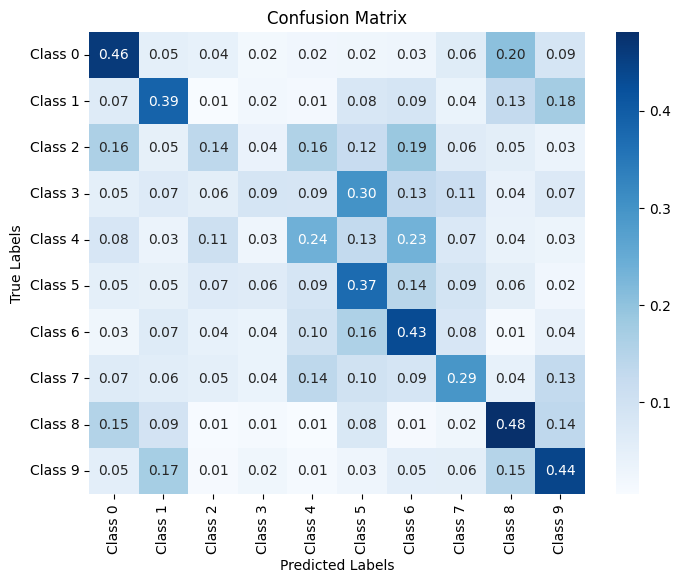

In [19]:
model1 = Model1MLP().to(device)
loss_fun = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model1.parameters(),lr = 0.005,momentum=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,mode='min',factor=0.1,patience=10)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model(model1,train_data,train_labels,test_data,test_labels,loss_fun,optim,scheduler,epochs=200)
pred_labels = test_step(model1,test_data,test_labels,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels, pred_labels, class_names)

Παρ'όλα αυτά, εξακολουθούμε να μην συγκλίνουμε ικανοποιητικά, ενώ αυξήσαμε τα epochs στα 200. Το αποτέλεσμα που παίρνουμε είναι κοντά στο 30%. Αυτό συμβαίνει επειδή χρειάστηκε να χαμηλώσουμε αρκετά το learning rate, και ο scheduler που έχουμε δεν βοηθάει επειδή το χαμηλώνει ακόμη περισσότερο. Πολλές αλλαγές μπορούν να γίνουν, αρχικά π.χ. να αυξήσουμε το patience του scheduler ώστε να μην μας χαμηλώνει τόσο πολύ το learning rate όπως δείχνουμε παρακάτω.

epoch 0 	train loss: 2.73351 	test loss: 2.54722 	train_acc = 10.23	test_acc = 10.11 	lr=0.005
epoch 1 	train loss: 2.54072 	test loss: 2.35490 	train_acc = 10.05	test_acc = 9.68 	lr=0.005
epoch 2 	train loss: 2.35284 	test loss: 2.32238 	train_acc = 9.75	test_acc = 10.70 	lr=0.005
epoch 3 	train loss: 2.32091 	test loss: 2.29140 	train_acc = 10.89	test_acc = 12.76 	lr=0.005
epoch 4 	train loss: 2.29112 	test loss: 2.27670 	train_acc = 12.85	test_acc = 13.38 	lr=0.005
epoch 5 	train loss: 2.27678 	test loss: 2.26437 	train_acc = 13.64	test_acc = 13.98 	lr=0.005
epoch 6 	train loss: 2.26437 	test loss: 2.25258 	train_acc = 14.19	test_acc = 14.97 	lr=0.005
epoch 7 	train loss: 2.25218 	test loss: 2.24177 	train_acc = 15.34	test_acc = 15.42 	lr=0.005
epoch 8 	train loss: 2.24132 	test loss: 2.23349 	train_acc = 15.89	test_acc = 16.29 	lr=0.005
epoch 9 	train loss: 2.23284 	test loss: 2.23223 	train_acc = 16.83	test_acc = 15.56 	lr=0.005
epoch 10 	train loss: 2.23169 	test loss: 2.25642 	t

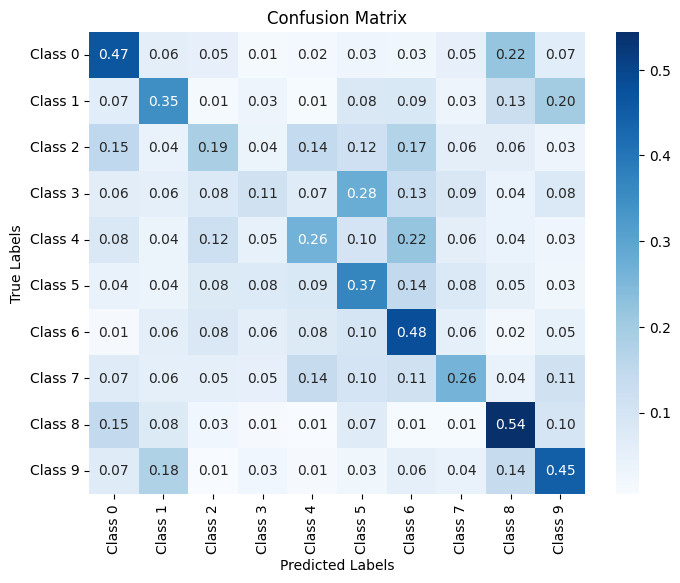

In [20]:
model1 = Model1MLP().to(device)
loss_fun = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model1.parameters(),lr = 0.005,momentum=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,mode='min',factor=0.1,patience=30)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model(model1,train_data,train_labels,test_data,test_labels,loss_fun,optim,scheduler,epochs=200)
pred_labels = test_step(model1,test_data,test_labels,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels, pred_labels, class_names)

Δεν βοηθάει όμως πολύ κάτι τέτοιο, επειδή ηδη ξεκινάμε με ένα πολύ μικρό learning rate και η σύγκλισή μας είναι πολύ αργή, ενώ φαίνεται να φτάνει σε ενα σταθερό σημείο με accuracy περίπου 30% χωρίς να αυξάνεται παραπάνω.

Το μοντέλο μας μπορεί να βελτιωθεί δραματικά, με batch normalization μετά από κάθε layer. Το batch normalization κανονικοποιεί τις εξόδους μας και εξασφαλίζει ότι η έξοδος κάθε layer είναι consistent ως προς το μέγεθος. Γενικά το batch normalization είναι καλή πρακτική στα MLPs επειδή λύνει πολλά από τα προβλήματα που αναφέρθηκαν προηγουμένως. Συγκεκριμένα, τα vanishing και τα exploding gradients μπορούν να βοηθηθούν αρκετά μέσω του batch normalization. Ας φτιάξουμε λοιπόν ένα 3ο μοντέλο που θα είναι ίδιο με το 2ο, απλά θα υλοποιεί batch normalization μετά από κάθε layer. Για την ακρίβεια, μετά από μερικές τροποποιήσεις παρατηρήσαμε ότι ενα μοντέλο με λιγότερα hidden layers είναι το ίδιο αποδοτικό, οπότε μειώσαμε τα hidden layers σε ενα μόνο, μιας και το accuracy δεν επηρεάζεται τελικά με την πρόσθεση περισσότερων hidden layers με 100 inputs και outputs το καθένα. Με αυτόν τον τρόπο μπορούμε να εκπαιδεύσουμε το μοντέλο για περισσότερα epochs στον ίδιο χρόνο, και πιθανώς να αυξήσουμε την αποδοτικότητά του ως προς την εκπαίδευση.

In [21]:
class Model2MLP(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fwd_layer = nn.Sequential(
            nn.Linear(in_features=3072,out_features=100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(in_features=100,out_features=100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(in_features=100,out_features=10),
        )
    def forward(self,x:torch.Tensor):
        return self.fwd_layer(x)

epoch 0 	train loss: 2.38932 	test loss: 9.99303 	train_acc = 9.46	test_acc = 14.27 	lr=0.5
epoch 1 	train loss: 2.10509 	test loss: 2.88546 	train_acc = 25.15	test_acc = 13.79 	lr=0.5
epoch 2 	train loss: 2.00207 	test loss: 2.49156 	train_acc = 30.93	test_acc = 18.52 	lr=0.5
epoch 3 	train loss: 1.93139 	test loss: 2.09591 	train_acc = 32.94	test_acc = 21.45 	lr=0.5
epoch 4 	train loss: 1.88879 	test loss: 2.79719 	train_acc = 35.18	test_acc = 18.27 	lr=0.5
epoch 5 	train loss: 1.88555 	test loss: 2.19021 	train_acc = 33.67	test_acc = 17.41 	lr=0.5
epoch 6 	train loss: 1.84609 	test loss: 2.34819 	train_acc = 35.35	test_acc = 20.29 	lr=0.5
epoch 7 	train loss: 1.84670 	test loss: 2.01558 	train_acc = 34.53	test_acc = 25.90 	lr=0.5
epoch 8 	train loss: 1.79118 	test loss: 2.03132 	train_acc = 37.04	test_acc = 27.59 	lr=0.5
epoch 9 	train loss: 1.77290 	test loss: 2.06305 	train_acc = 36.56	test_acc = 23.92 	lr=0.5
epoch 10 	train loss: 1.79517 	test loss: 2.53212 	train_acc = 35.56	te

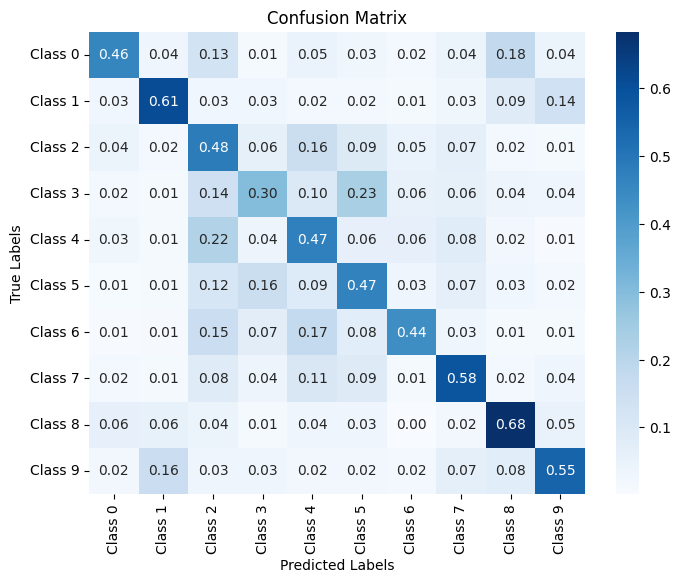

In [22]:
model2 = Model2MLP().to(device)
loss_fun = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model2.parameters(),lr = 0.5,momentum=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,mode='min',factor=0.1,patience=10)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model(model2,train_data,train_labels,test_data,test_labels,loss_fun,optim,scheduler,epochs=300)
pred_labels = test_step(model2,test_data,test_labels,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels, pred_labels, class_names)

Επιτέλους, φαίνεται να έχουμε πετύχει ενα ποσοστό επιτυχίας περισσότερο από 50%, κάτι που αν και δεν είναι αρκετά καλό ως λύση του προβλήματός μας, μας δίνει ελπίδες ότι ίσως με περισσότερα hidden layers μπορέσουμε να βελτιώσουμε το νευρωνικό μας δραματικά.

In [13]:
class Model3MLP(nn.Module):
    def __init__(self, in_features=3072, out_features=10, hidden_units=500):
        super().__init__()
        self.fwd_layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            #nn.BatchNorm1d(hidden_units),
            nn.ReLU(), 
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            #nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            #nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
        )

    def forward(self,x:torch.Tensor):
        return self.fwd_layer(x)

Εδω είναι που το νευρωνικό μας αρχίζει να γίνεται αρκετά απαιτητικό όσων αφορά τους πόρους της GPU μας. Στον δικό μας υπολογιστή, το νευρωνικό αυτό δεν μπορεί να εκπαιδευτεί επειδή η VRAM της GPU μας δεν αρκεί για την αποθήκευση τόσων μεταβλητών. Παρ'όλα αυτά, η GPU μας είναι σχετικά αδύναμη, με VRAM μόνο 3gb.

Εξηγήσαμε παραπάνω ότι το training με batches μας επιτρέπει να λύσουμε πολύπλοκα νευρωνικά με περιορισμένους πόρους. Έχοντας ετοιμάσει ηδη τον κώδικά μας ώστε να μπορεί εύκολα να γίνει η αλλαγή, επιλέγουμε τώρα να εκπαιδεύσουμε το νευρωνικό μας με τη χρήση batches. Υπογραμμίζουμε ότι ο χρόνος εκπαίδευσης παραμένει πολύ υψηλός λόγω του τεράστιου αριθμού παραμέτρων στα hidden units. Δεν υπάρχει καλύτερη λύση για αυτό χωρίς αναβάθμιση της μηχανής μας.

Επίσης, αφαιρέσαμε το Batch Normalization επειδή το νευρωνικό μας όπως θα δούμε στη συνέχεια, κάνει overfit πολύ γρήγορα. Με το Batch Normalization, το νευρωνικό θα έκανε overfit αμέσως.

epoch 0 	train loss: 2.32585 	test loss: 1.83866 	train_acc = 24.67	test_acc = 33.87 	lr=0.001
epoch 1 	train loss: 1.80485 	test loss: 1.70639 	train_acc = 34.75	test_acc = 39.39 	lr=0.001
epoch 2 	train loss: 1.72117 	test loss: 1.65411 	train_acc = 38.22	test_acc = 41.50 	lr=0.001
epoch 3 	train loss: 1.66426 	test loss: 1.73496 	train_acc = 40.39	test_acc = 38.94 	lr=0.001
epoch 4 	train loss: 1.61796 	test loss: 1.65134 	train_acc = 41.95	test_acc = 41.42 	lr=0.001
epoch 5 	train loss: 1.57845 	test loss: 1.62791 	train_acc = 43.61	test_acc = 42.71 	lr=0.001
epoch 6 	train loss: 1.54440 	test loss: 1.59533 	train_acc = 44.82	test_acc = 43.66 	lr=0.001
epoch 7 	train loss: 1.51325 	test loss: 1.61458 	train_acc = 45.84	test_acc = 43.33 	lr=0.001
epoch 8 	train loss: 1.48478 	test loss: 1.59839 	train_acc = 46.71	test_acc = 43.65 	lr=0.001
epoch 9 	train loss: 1.45988 	test loss: 1.61414 	train_acc = 47.78	test_acc = 44.09 	lr=0.001
epoch 10 	train loss: 1.43559 	test loss: 1.55035 

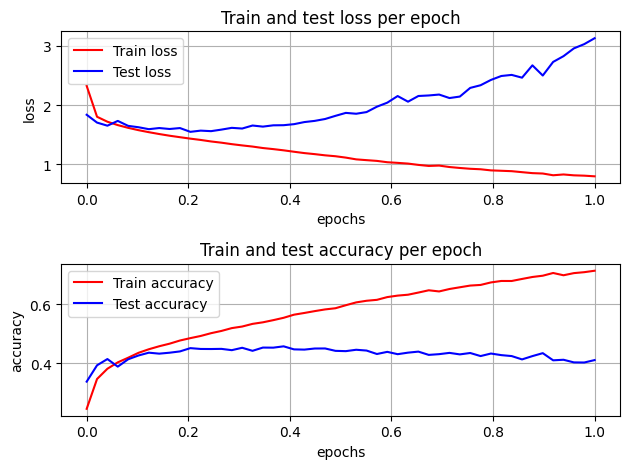

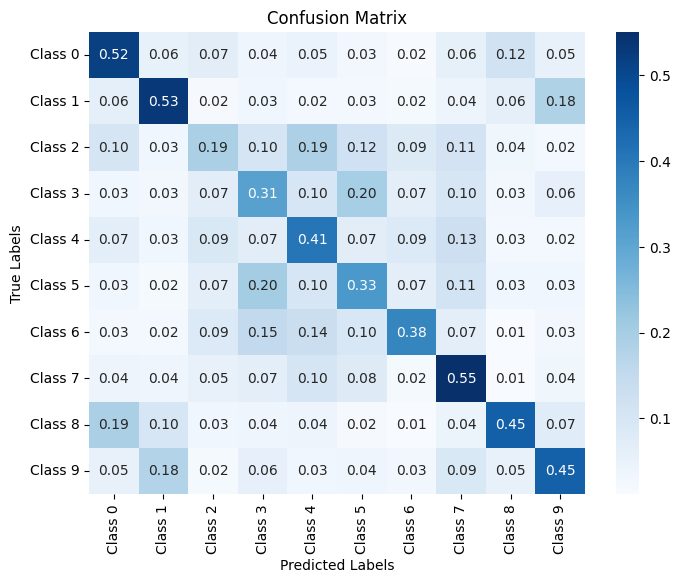

In [24]:
model3 = Model3MLP().to(device)
loss_fun = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model3.parameters(),lr = 0.001,momentum = 0.7)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model_batch(model3,train_dataloader,test_dataloader,loss_fun,optim,epochs=50)
plot_graphs(train_losses,test_losses,train_accuracies,test_accuracies)
pred_labels = test_step_batch(model3,test_dataloader,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels, pred_labels, class_names)



Παρατηρούμε πολύ ξεκάθαρα ότι έχουμε overfitting στην περίπτωση του συγκεκριμένου νευρωνικού, καθώς και ότι το test accuracy δεν ανεβαίνει πολύ ψηλότερα του 40%. Το overfitting φαίνεται από το γεγονός ότι ενω το train loss τείνει στο 0, το test loss ολο και αυξάνεται. Αυτό φαίνεται και από το accuracy, το οποίο στο training τείνει στο 100% ενώ στο test αρχικά αυξάνεται αλλά αμέσως μετά μειώνεται σταδιακά.

Φαίνεται να έχουμε φτάσει στα limitations αυτού του μοντέλου. Αν αυξήσουμε τα hidden units το overfitting γίνεται ακόμη πιο μεγάλο. Μπορούμε να προσθέσουμε περισσότερα hidden layers αλλά μετά από πειράματα, φαίνεται ότι το accuracy ακόμη και τότε δεν αυξάνεται σημαντικά σε σχέση με τα αποτελέσματά μας τώρα, ενώ τα μοντέλα έχουν μεγάλες απαιτήσεις σε υπολογιστικούς πόρους και χρόνο.

Επειδή η χρήση των HOG features βοήθησε στο accuracy των αλγορίθμων KNN και Nearest Centroid πολύ στην προηγούμενη εργασία, θα δοκιμάσουμε να δούμε αν το νευρωνικό μας θα δώσει καλύτερη απόδοση με την χρήση αυτών των features. Δημιουργούμε αρα ένα καινούριο νευρωνικό:

In [ ]:
class Model4MLP(nn.Module):
    def __init__(self, in_features=3072, out_features=10, hidden_units=1000):
        super().__init__()
        self.fwd_layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(), 
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
        )

    def forward(self,x:torch.Tensor):
        return self.fwd_layer(x)

In [27]:
hog_features_train, hog_features_test = extract_hog_features(images_sep.cpu().numpy(),images_sep_t.cpu().numpy())

hog_features_train = torch.from_numpy(hog_features_train).to(device).type(torch.float32)
hog_features_test = torch.from_numpy(hog_features_test).to(device).type(torch.float32)

epoch 0 	train loss: 6.96914 	test loss: 6.86760 	train_acc = 0.04	test_acc = 10.00 	lr=0.1
epoch 1 	train loss: 5.13470 	test loss: 6.72137 	train_acc = 26.30	test_acc = 11.64 	lr=0.1
epoch 2 	train loss: 2.71270 	test loss: 6.45944 	train_acc = 34.88	test_acc = 10.13 	lr=0.1
epoch 3 	train loss: 1.78021 	test loss: 6.12895 	train_acc = 42.26	test_acc = 10.01 	lr=0.1
epoch 4 	train loss: 1.57730 	test loss: 5.75281 	train_acc = 46.29	test_acc = 10.00 	lr=0.1
epoch 5 	train loss: 1.50987 	test loss: 5.34663 	train_acc = 47.71	test_acc = 10.53 	lr=0.1
epoch 6 	train loss: 1.43960 	test loss: 4.92424 	train_acc = 50.39	test_acc = 12.79 	lr=0.1
epoch 7 	train loss: 1.38978 	test loss: 4.49980 	train_acc = 51.88	test_acc = 13.48 	lr=0.1
epoch 8 	train loss: 1.34259 	test loss: 4.09063 	train_acc = 53.42	test_acc = 13.15 	lr=0.1
epoch 9 	train loss: 1.30643 	test loss: 3.71573 	train_acc = 54.63	test_acc = 14.11 	lr=0.1
epoch 10 	train loss: 1.27598 	test loss: 3.39219 	train_acc = 55.77	te

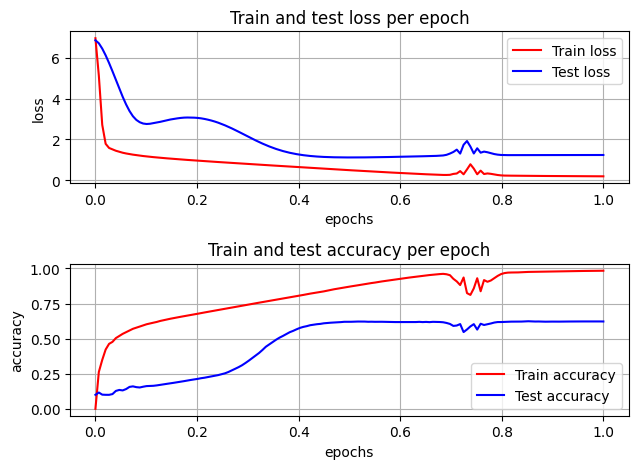

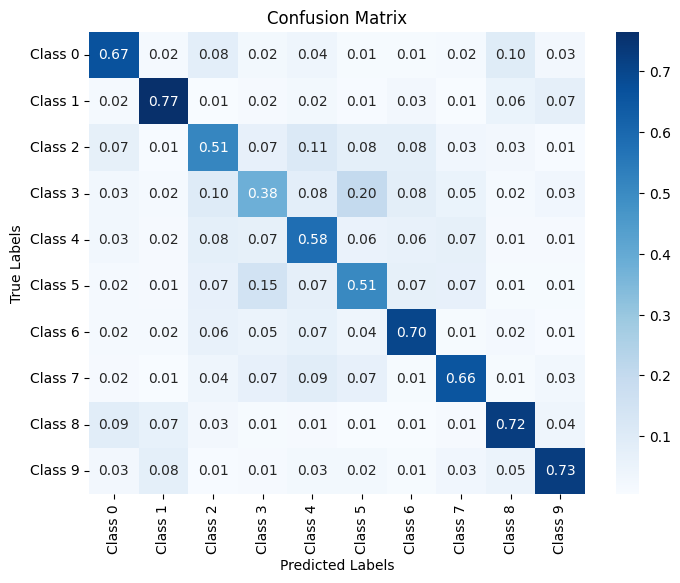

In [28]:
model3hog= Model4MLP(in_features=324).to(device)
loss_fun = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model3hog.parameters(),lr = 0.1,momentum = 0.7)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,mode='min',factor=0.1,patience=10)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model(model3hog,hog_features_train,train_labels,hog_features_test,test_labels,loss_fun,optim,scheduler,epochs=150)
plot_graphs(train_losses,test_losses,train_accuracies,test_accuracies)
pred_labels = test_step(model3hog,hog_features_test,test_labels,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels, pred_labels, class_names)

Παρατηρούμε ότι και εδώ η χρήση HOG features μας επέτρεψε να φτάσουμε περίπου στο 60% accuracy. Επίσης, το νευρωνικό μας έχει κατά μια τάξη μεγέθους μικρότερη είσοδο και άρα είναι πιο αποδοτικό από τα προηγούμενα. Φαίνεται πως η προεργασία της εικόνας αξίζει τον χρόνο που παίρνει για τα τελικά αποτελέσματα που λαμβάνουμε από το νευρωνικό μας.

Αφήσαμε το training να τρέξει για 150 epochs αλλά φαίνεται ότι έχουμε overfitting μετά από περίπου 100 epochs, οπότε τελικά θα χρησιμοποιούσαμε ενα μοντέλο που έχει εκπαιδευτεί λιγότερο.

**Συνελικτικά Νευρωνικά Δίκτυα**

Ψάχνοντας στο διαδίκτυο για λύσεις των προβλημάτων που προέκυψαν για τα fully connected MLPs μας, δεν μπορούσαμε να αγνοήσουμε την πληροφορία ότι για εικόνες, η χρήση των συνελικτικών νευρωνικών δικτύων είναι προτιμότερη. Τα συνελικτικά νευρωνικά δίκτυα (CNNs) είναι δίκτυα σχεδιασμένα συγκεκριμένα για δεδομένα όπως ο ήχος ή οι εικόνες, όπου τα MLPs δεν αποδίδουν πολύ καλά.

Τα Συνελικτικά νευρωνικά δίκτυα χρησιμοποιούν πράξεις όπως η συνέλιξη, ή το max pooling για την εικόνα, ώστε να εξάγουν features χρήσιμα στην κατηγοριοποίηση εικόνων. Έχει αποδειχτεί ότι ένα CNN που εκτελεί τις πράξεις αυτές μας οδηγεί γενικά σε καλύτερα αποτελέσματα accuracy από ένα MLP. 

Η πράξη της συνέλιξης γίνεται με τη μετακίνηση μιας τετραγωνικής μάσκας πάνω στην εικόνα. Η μάσκα αυτή στην περίπτωσή μας είναι 3x3. Καθώς η μάσκα μετακινείται, προσθέτει τις τιμές των pixels που καλύπτει και δημιουργεί ένα καινούριο pixel που αποτελεί συνέλιξη των προηγουμένων. Ταυτόχρονα, υπάρχει η επιλογή να εισάγουμε padding στην εικόνα, αυξάνοντας τις διαστάσεις της και βάζοντας pixels με μηδενική τιμή στα άκρα. Στην περίπτωσή μας το padding είναι μηδενικό.

Η πράξη του MaxPooling είναι παρόμοια με αυτή της συνέλιξης μιας και πάλι περιγράφεται από την μετακίνηση μιας τετραγωνικής μάσκας πάνω στην εικόνα, αλλά αυτή τη φορά επιλέγεται το pixel το οποίο έχει τη μέγιστη τιμή. Στη συνέχεια, δημιουργείται ένα pixel στην καινούρια εικόνα (έξοδο) που έχει την τιμή αυτή. Η μάσκα μας εδώ είναι 2x2.

Το τελικό layer είναι γραμμικό, και αποτελεί τον κατηγοριοποιητή μας, μιας και υποθέτουμε τώρα ότι το πρόβλημά μας μέσω των προηγούμενων layers εχει γίνει γραμμικό. Έχουμε βάλει δύο γραμμικά layers πριν την έξοδο αλλά γενικά φαίνεται ότι και ένα layer θα δούλευε αρκετά ικανοποιητικά.

Υπάρχουν διάφορα εργαλεία για την κατανόηση των CNNs στο διαδίκτυο, το πιο βοηθητικό όμως ήταν αυτή η ιστοσελίδα: https://poloclub.github.io/cnn-explainer/

In [14]:
class CNN0(nn.Module):
    def __init__(self, input_shape: int = 3, hidden_units: int = 15, output_shape: int = 10):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*27*27,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.block1(x)
        x = self.classifier(x)

        return x

In [13]:
cnn_model_0 = CNN0().to(device)
loss_fun = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=cnn_model_0.parameters(),lr = 0.09)

epoch 0 	train loss: 2.30974 	test loss: 2.30319 	train_acc = 9.84	test_acc = 10.01 	lr=0.09
epoch 1 	train loss: 2.30337 	test loss: 2.30318 	train_acc = 9.67	test_acc = 10.01 	lr=0.09
epoch 2 	train loss: 2.30336 	test loss: 2.30318 	train_acc = 9.67	test_acc = 10.02 	lr=0.09
epoch 3 	train loss: 2.30335 	test loss: 2.30318 	train_acc = 9.69	test_acc = 10.00 	lr=0.09
epoch 4 	train loss: 2.30336 	test loss: 2.30318 	train_acc = 9.68	test_acc = 10.02 	lr=0.09
epoch 5 	train loss: 2.30334 	test loss: 2.30330 	train_acc = 9.68	test_acc = 10.00 	lr=0.09
epoch 6 	train loss: 2.30448 	test loss: 2.30256 	train_acc = 9.69	test_acc = 10.11 	lr=0.09
epoch 7 	train loss: 2.27014 	test loss: 2.30317 	train_acc = 12.70	test_acc = 10.01 	lr=0.09
epoch 8 	train loss: 2.30336 	test loss: 2.30317 	train_acc = 9.67	test_acc = 10.01 	lr=0.09
epoch 9 	train loss: 2.30336 	test loss: 2.30317 	train_acc = 9.66	test_acc = 10.01 	lr=0.09
epoch 10 	train loss: 2.30497 	test loss: 2.30317 	train_acc = 9.73	t

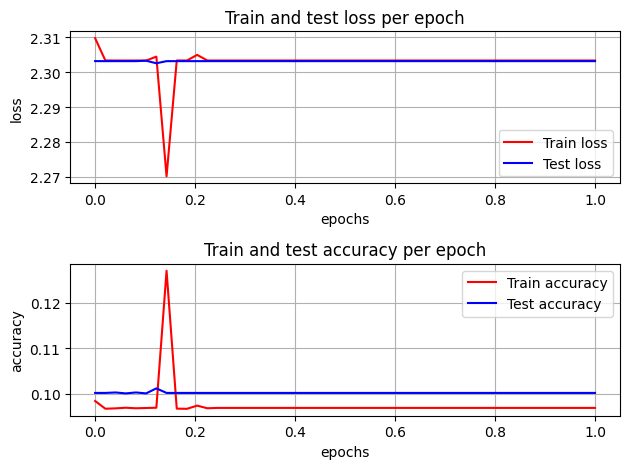

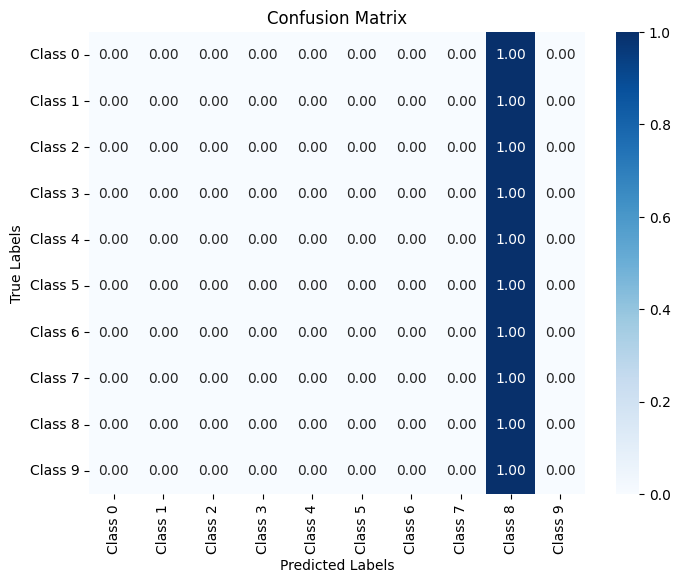

In [14]:
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model_batch(cnn_model_0,train_dataloader_img,test_dataloader_img,loss_fun,optim,epochs=50)
plot_graphs(train_losses,test_losses,train_accuracies,test_accuracies)

pred_labels = test_step(cnn_model_0,images_sep_t,test_labels,loss_fun,return_preds=True)
class_names = ['Class 0', 'Class 1', 'Class 2','Class 3','Class 4','Class 5','Class 6','Class 7','Class 8','Class 9']
# Plot the confusion matrix
plot_confusion_matrix(test_labels, pred_labels, class_names)

Το νευρωνικό μας δεν μαθαίνει και πάλι... Η χρήση Batch Normalization είναι πρακτικά απαραίτητη στα CNNs λόγω της πράξης συνέλιξης, η οποία προσθέτει τα pixels κάτω από τη μάσκα. Έτσι είναι πολύ εύκολο να καταλήξουμε σε εκθετικά μεγάλες τιμές εξόδου αν εκτελέσουμε αυτή την πράξη πολλές φορές χωρίς τη χρήση Batch Normalization. Δημιουργούμε λοιπόν το επόμενο νευρωνικό μας το οποίο εκτελεί Batch Normalization σε κάθε layer του 1ου block.

In [19]:
class CNN1(nn.Module):
    def __init__(self, input_shape: int = 3, hidden_units: int = 32, output_shape: int = 10):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*27*27,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.block1(x)
        x = self.classifier(x)

        return x

In [20]:
cnn_model_1 = CNN1().to(device)
loss_fun = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=cnn_model_1.parameters(),lr = 0.09)

epoch 0 	train loss: 2.10444 	test loss: 1.91535 	train_acc = 17.73	test_acc = 27.57 	lr=0.09
epoch 1 	train loss: 1.54344 	test loss: 1.65533 	train_acc = 42.32	test_acc = 37.57 	lr=0.09
epoch 2 	train loss: 1.23286 	test loss: 1.37038 	train_acc = 56.23	test_acc = 51.51 	lr=0.09
epoch 3 	train loss: 1.09453 	test loss: 1.32031 	train_acc = 61.80	test_acc = 54.26 	lr=0.09
epoch 4 	train loss: 1.00337 	test loss: 1.41757 	train_acc = 64.99	test_acc = 51.25 	lr=0.09
epoch 5 	train loss: 0.92314 	test loss: 1.48548 	train_acc = 67.64	test_acc = 50.61 	lr=0.09
epoch 6 	train loss: 0.83506 	test loss: 1.42527 	train_acc = 71.09	test_acc = 54.21 	lr=0.09
epoch 7 	train loss: 0.75932 	test loss: 1.44301 	train_acc = 73.62	test_acc = 55.74 	lr=0.09
epoch 8 	train loss: 0.69135 	test loss: 1.81926 	train_acc = 75.94	test_acc = 51.46 	lr=0.09
epoch 9 	train loss: 0.63440 	test loss: 1.61607 	train_acc = 77.76	test_acc = 56.21 	lr=0.09
epoch 10 	train loss: 0.58077 	test loss: 1.82647 	train_acc

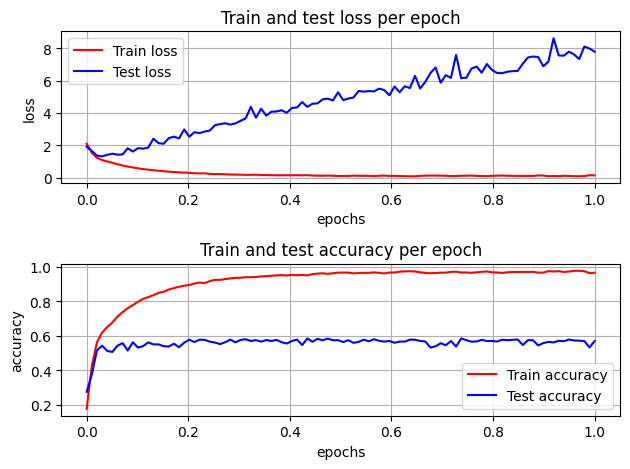

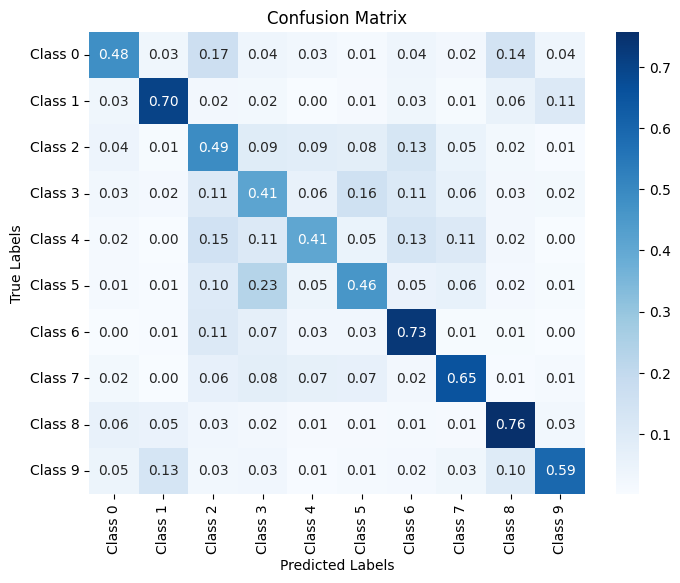

In [21]:

train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model_batch(cnn_model_1,train_dataloader_img,test_dataloader_img,loss_fun,optim,epochs=100)
plot_graphs(train_losses,test_losses,train_accuracies,test_accuracies)

pred_labels = test_step(cnn_model_1,images_sep_t,test_labels,loss_fun,return_preds=True)
class_names = ['Class 0', 'Class 1', 'Class 2','Class 3','Class 4','Class 5','Class 6','Class 7','Class 8','Class 9']
# Plot the confusion matrix
plot_confusion_matrix(test_labels, pred_labels, class_names)

Παρατηρούμε ξεκάθαρα το overfitting.

Δημιουργήσαμε παρακάτω ένα νεο νευρωνικό που προσθέτει κιάλλο block από hidden layers και εκτελεί περισσότερες πράξεις συνέλιξης και MaxPooling, έτσι ώστε να δούμε πόσο υψηλό accuracy μπορούμε να πετύχουμε.

Επίσης προσθέσαμε στον νευρωνικό μας Dropout. Δηλαδή, μετά από κάθε block από hidden layers, δημιουργήσαμε ένα layer `nn.Dropout`. Αυτό, με πιθανότητα που επιλέγουμε - στην περίπτωσή μας 0.2, που στη βιβλιογραφία συνίσταται -, απενεργοποιεί κάθε hidden unit. Αυτό μας βοηθά να καταπολεμήσουμε το overfitting και βοηθά το μοντέλο να είναι πιο εύρωστο και να μην μαθαίνει τόσο τον θόρυβο. Αν για παράδειγμα ένα hidden unit γίνει πολύ καλό στην αναγνώριση συγκεκριμένων features, το νευρωνικό μας θα είναι βασισμένο πολύ στο συγκεκριμένο hidden unit, ενώ τα υπόλοιπα hidden units θα εκπαιδευτούν με βάση μια τέτοια δυναμική, κάτι που οδηγεί σε overfitting. Απενεργοποιώντας τυχαία κάποια hidden units ανα epoch, το νευρωνικό μας αναγκάζεται να μάθει πιο ισορροπημένα.

In [35]:
class CNN2(nn.Module):
    def __init__(self, input_shape: int = 3, hidden_units: int = 32, output_shape: int = 10):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=1),
            nn.Dropout(0.2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units,hidden_units,3,padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units,hidden_units,3,padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        # self.block3 = nn.Sequential(
        #     nn.Conv2d(hidden_units,hidden_units,3,padding=0),
        #     nn.ReLU(),
        #     nn.Conv2d(hidden_units,hidden_units,3,padding=0),
        #     nn.MaxPool2d(2),
        #     nn.Dropout(0.2)
        # )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*11*11,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.block1(x)

        x = self.block2(x)
        #x = self.block3(x)
        #print(x.shape)
        x = self.classifier(x)

        return x

In [36]:
cnn_model_2 = CNN2().to(device)
loss_fun = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=cnn_model_2.parameters(),lr = 0.09)

epoch 0 	train loss: 1.40880 	test loss: 1.47531 	train_acc = 49.70	test_acc = 49.71 	lr=0.09
epoch 1 	train loss: 1.00941 	test loss: 1.17079 	train_acc = 65.04	test_acc = 59.35 	lr=0.09
epoch 2 	train loss: 0.89388 	test loss: 1.06487 	train_acc = 68.99	test_acc = 63.48 	lr=0.09
epoch 3 	train loss: 0.82397 	test loss: 0.95400 	train_acc = 71.35	test_acc = 67.89 	lr=0.09
epoch 4 	train loss: 0.77568 	test loss: 1.06248 	train_acc = 72.87	test_acc = 64.91 	lr=0.09
epoch 5 	train loss: 0.73689 	test loss: 0.91486 	train_acc = 74.26	test_acc = 69.34 	lr=0.09
epoch 6 	train loss: 0.70352 	test loss: 0.85775 	train_acc = 75.42	test_acc = 71.82 	lr=0.09
epoch 7 	train loss: 0.68071 	test loss: 0.88842 	train_acc = 76.11	test_acc = 71.06 	lr=0.09
epoch 8 	train loss: 0.65339 	test loss: 0.88013 	train_acc = 77.04	test_acc = 71.58 	lr=0.09
epoch 9 	train loss: 0.63100 	test loss: 0.93229 	train_acc = 77.90	test_acc = 70.27 	lr=0.09
epoch 10 	train loss: 0.61245 	test loss: 0.94365 	train_acc

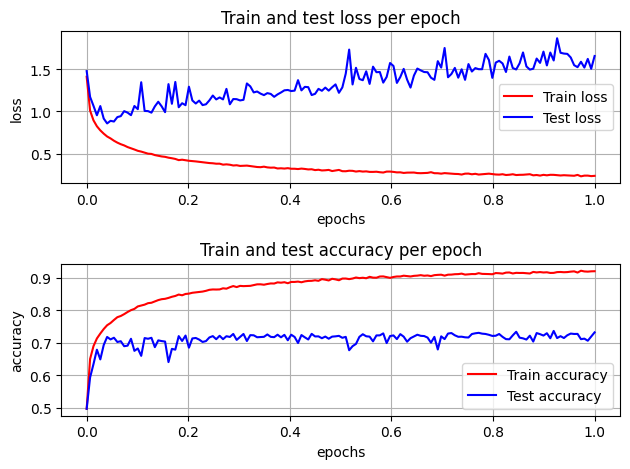

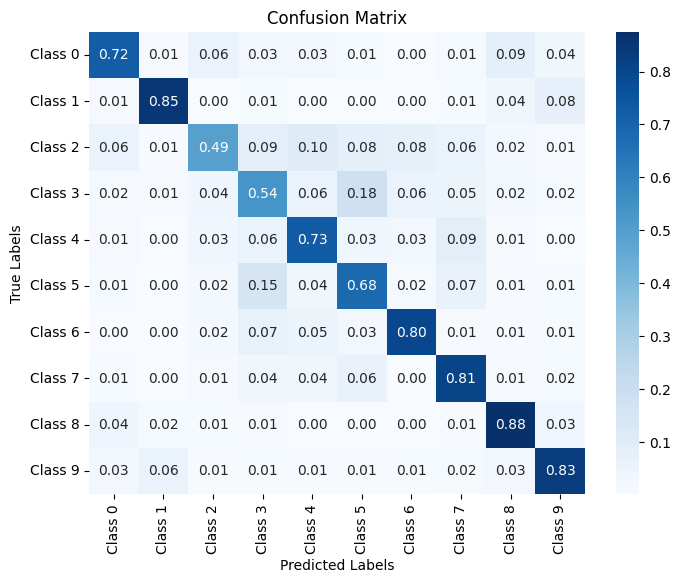

In [37]:
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model_batch(cnn_model_2,train_dataloader_img,test_dataloader_img,loss_fun,optim,epochs=150)
plot_graphs(train_losses,test_losses,train_accuracies,test_accuracies)

pred_labels = test_step(cnn_model_2,images_sep_t,test_labels,loss_fun,return_preds=True)
class_names = ['Class 0', 'Class 1', 'Class 2','Class 3','Class 4','Class 5','Class 6','Class 7','Class 8','Class 9']
# Plot the confusion matrix
plot_confusion_matrix(test_labels, pred_labels, class_names)

Παρατηρούμε ότι το accuracy μας είναι 70%, αλλά έχουμε ξεκάθαρο overfitting και το μοντέλο μας δεν μαθαίνει μετά από κάποια epochs. Βλέπουμε ότι ενώ το test loss αυξάνεται, το accuracy παραμένει περίπου ίδιο, κοντά στο 70%. Ακολουθώντας την ίδια παράδοση με πρίν, υποθέτουμε ότι μπορούμε να πετύχουμε καλύτερο accuracy αυξάνοντας την πολυπλοκότητα του μοντέλου. Προσθέτουμε λοιπόν ενα 3ο block από hidden layers.

In [38]:
class CNN3(nn.Module):
    def __init__(self, input_shape: int = 3, hidden_units: int = 32, output_shape: int = 10):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=1),
            nn.Dropout(0.2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units,hidden_units,3,padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units,hidden_units,3,padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(hidden_units,hidden_units,3,padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units,hidden_units,3,padding=0),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*3*3,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.block1(x)

        x = self.block2(x)
        x = self.block3(x)
        #print(x.shape)
        x = self.classifier(x)

        return x

In [39]:
cnn_model_3 = CNN3().to(device)
loss_fun = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=cnn_model_3.parameters(),lr = 0.09)

epoch 0 	train loss: 1.58996 	test loss: 1.99473 	train_acc = 41.51	test_acc = 37.27 	lr=0.09
epoch 1 	train loss: 1.26108 	test loss: 1.50463 	train_acc = 54.93	test_acc = 50.29 	lr=0.09
epoch 2 	train loss: 1.12428 	test loss: 1.45585 	train_acc = 60.11	test_acc = 52.16 	lr=0.09
epoch 3 	train loss: 1.04117 	test loss: 1.22096 	train_acc = 63.31	test_acc = 57.46 	lr=0.09
epoch 4 	train loss: 0.98851 	test loss: 1.16122 	train_acc = 64.97	test_acc = 60.25 	lr=0.09
epoch 5 	train loss: 0.95518 	test loss: 1.01847 	train_acc = 66.37	test_acc = 63.91 	lr=0.09
epoch 6 	train loss: 0.92501 	test loss: 1.07889 	train_acc = 67.46	test_acc = 62.52 	lr=0.09
epoch 7 	train loss: 0.90249 	test loss: 1.00135 	train_acc = 68.30	test_acc = 65.63 	lr=0.09
epoch 8 	train loss: 0.88343 	test loss: 0.95427 	train_acc = 69.05	test_acc = 67.11 	lr=0.09
epoch 9 	train loss: 0.86947 	test loss: 0.89476 	train_acc = 69.48	test_acc = 69.19 	lr=0.09
epoch 10 	train loss: 0.85011 	test loss: 0.95381 	train_acc

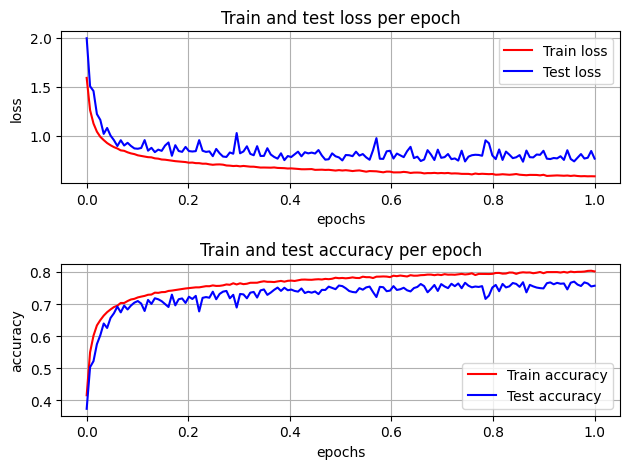

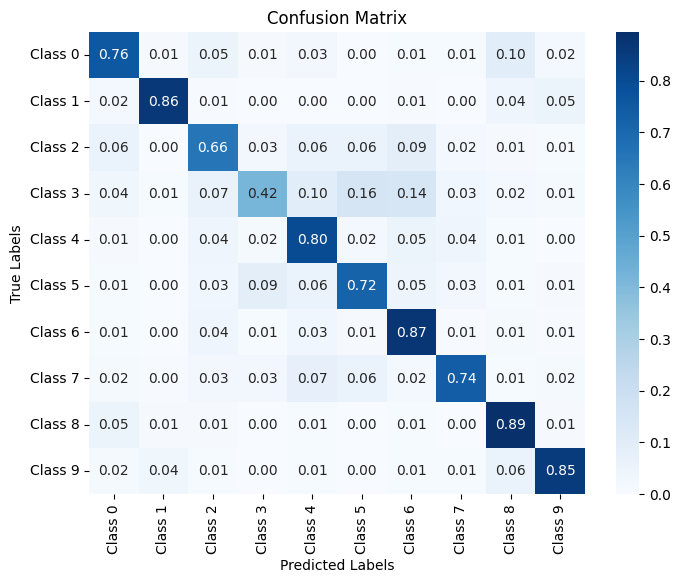

In [40]:
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model_batch(cnn_model_3,train_dataloader_img,test_dataloader_img,loss_fun,optim,epochs=150)
plot_graphs(train_losses,test_losses,train_accuracies,test_accuracies)

pred_labels = test_step(cnn_model_3,images_sep_t,test_labels,loss_fun,return_preds=True)
class_names = ['Class 0', 'Class 1', 'Class 2','Class 3','Class 4','Class 5','Class 6','Class 7','Class 8','Class 9']
# Plot the confusion matrix
plot_confusion_matrix(test_labels, pred_labels, class_names)

Τα πράγματα εδώ είναι πολύ καλύτερα. Έχουμε καταφέρει να αυξήσουμε το accuracy στο 75% και παρόλο που και πάλι παρατηρούμε overfitting, αυτό δεν είναι τόσο έντονο οσο προηγουμένως. Επίσης, παρατηρούμε σύγκλιση σχετικά γρήγορα σε καλό accuracy, κάτι που κάνει την απαίτηση του training σε epochs σχετικά μικρή. Αυτό ισχύει για ολα τα μοντέλα CNNs που δοκιμάστηκαν.

**Cross Validation**

Σε αυτή την στιγμή στην εργασία, αποφασίσαμε ότι δεν θα πειραματιστούμε περισσότερο με τη δομή του CNN μιας και αυτή είχε ηδη γίνει σχετικά πολύπλοκη, και θα προσπαθήσουμε να γράψουμε κώδικα για την εκτέλεση του cross validation του μοντέλου μας έτσι ώστε να δούμε πώς λειτουργεί ο αλγόριθμος, καθώς και να δούμε αν μπορούμε να πετύχουμε καλύτερο αποτέλεσμα σε accuracy.

Δημιουργήσαμε λοιπόν το CNN4 που είναι πρακτικά ίδιο με το CNN3, αλλά αυτή τη φορά θα το χρησιμοποιήσουμε για την εκτέλεση cross validation.

In [15]:
class CNN4(nn.Module):
    def __init__(self, input_shape: int = 3, hidden_units: int = 32, output_shape: int = 10):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=1),
            nn.Dropout(0.2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units,hidden_units,3,padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units,hidden_units,3,padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(hidden_units,hidden_units,3,padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units,hidden_units,3,padding=0),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*3*3,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.block1(x)

        x = self.block2(x)
        x = self.block3(x)
        #print(x.shape)
        x = self.classifier(x)

        return x

Παρακάτω παρουσιάζουμε την συνάρτηση cross vadiation η οποία δέχεται ως είσοδο ολόκληρο το dataset και τα labels, δέχεται την μεταβλητή `splits` η οποία λέει σε πόσα κομμάτια να χωρίσει το dataset και την μεταβλητή `epochs` για τα epochs που θα τρέξει σε κάθε μοντέλο.

Αρχικά, χωρίζουμε το dataset και θέτουμε ως test data ένα κομμάτι αυτού. Έπειτα εκτελούμε το training και αποθηκεύουμε το μοντέλο σε μια λίστα. Στο τέλος του αλγορίθμου, επιστρέφεται η λίστα με όλα τα μοντέλα μας.

Η συνάρτηση get_model_mean παίρνει τις παραμέτρους (δηλαδή το `state dict` κάθε μοντέλου) και επιστρέφει ένα μοντέλο που έχει ως παραμέτρους τον μέσο όρο των προηγούμενων. 

Η συνάρτηση get_best_model βρίσκει το μοντέλο που έχει το μεγαλύτερο accuracy στα test data του dataset και το επιστρέφει.

In [13]:
from collections import defaultdict
def cross_validation(loss_fun,dataset:np.array,labels:np.array,splits:int=10,epochs:int=100):
    models = []
    for i in range(splits):
        cross_valid_model = CNN4().to(device)
        models.append(cross_valid_model)
        optimizer = torch.optim.SGD(params = cross_valid_model.parameters(),lr = 0.09)
        split_set = np.vsplit(dataset,splits)
        split_lab = np.hsplit(labels,splits)
        test_data = split_set[i]
        test_labels = split_lab[i]
        split_set.pop(i)
        split_lab.pop(i)
        train_data = np.vstack(split_set)
        train_labels=  np.hstack(split_lab)
        tr_data = TensorDataset(torch.from_numpy(train_data).type(torch.float32).to(device),torch.from_numpy(train_labels).to(device))
        te_data = TensorDataset(torch.from_numpy(test_data).type(torch.float32).to(device),torch.from_numpy(test_labels).to(device))
        train_dataloader = DataLoader(tr_data,batch_size=BATCH_SIZE,shuffle=False)
        test_dataloader = DataLoader(te_data,batch_size=BATCH_SIZE,shuffle=False)

        train_losses = np.zeros(epochs)
        test_losses = np.zeros(epochs)
        accuracies = np.zeros(epochs)
        p = Path("cross_validation/")
        if(not p.is_dir()):
            p.mkdir(parents=True,exist_ok=True)
        fn = "model_test_validation_%d"%i
        filepath = p/fn
        train_features, train_labels = next(iter(train_dataloader))
        train_and_test_model_batch(cross_valid_model,train_dataloader,test_dataloader,loss_fun,optimizer,epochs=epochs)
        save_model_info(cross_valid_model,filepath)
    return models

def get_model_mean(models):
    all_params = []
    for model in models:
        model_params = []
        state_dict = model.state_dict()
        for key,value in state_dict.items():
            model_params.append(value)
        all_params.append(model_params)

    comb_model = CNN4().to(device)
    state_dict = comb_model.state_dict()

    result = [sum(row)/len(models) for row in zip(*all_params)]

    indx = 0
    for key, value in state_dict.items():
        state_dict[key] = result[indx]
        indx+=1
    comb_model.load_state_dict(state_dict)
    return comb_model

def get_best_model(models,test_dataloader,loss_fun):
    losses = np.zeros(len(models))
    accuracies = np.zeros(len(models))
    for indx,model in enumerate(models):
        losses[indx],accuracies[indx] = test_step_batch(model,test_dataloader,loss_fun)
    min_indx = np.argmin(losses)
    return models[min_indx],losses[min_indx],accuracies[min_indx]

def get_model_prediction(models,test_dataloader,loss_fun):
    predictions = [None]*len(models)
    for indx,model in enumerate(models):
        predictions[indx],_,_ = test_step_batch(model,test_dataloader,loss_fun, return_all=True)
    return predictions

Τρέχουμε λοιπόν τη συνάρτηση cross validation με `splits = 6`, μιας και το dataset μας έχει 60000 φωτογραφίες. Άρα τα testing data μας είναι 10000 και τα training data 50000. Το cross validation παίρνει πολύ χρόνο επειδή καταλήγουμε στην εκπαίδευση 6 μοντέλων για 150 epochs, κάτι που είναι χρονοβόρο και υπολογιστικά βαρύ. Ελπίζουμε τα αποτελέσματα να είναι ικανοποιητικά.

In [ ]:
loss_fun = nn.CrossEntropyLoss()
models = cross_validation(loss_fun,dataset_img,labels,6,epochs=50)

epoch 0 	train loss: 1.61054 	test loss: 1.48732 	train_acc = 41.01	test_acc = 48.27 	lr=0.09
epoch 1 	train loss: 1.28359 	test loss: 1.38715 	train_acc = 54.11	test_acc = 53.58 	lr=0.09
epoch 2 	train loss: 1.14429 	test loss: 1.09949 	train_acc = 59.35	test_acc = 61.28 	lr=0.09
epoch 3 	train loss: 1.05599 	test loss: 1.03509 	train_acc = 62.92	test_acc = 63.55 	lr=0.09
epoch 4 	train loss: 1.00372 	test loss: 1.06876 	train_acc = 64.70	test_acc = 61.84 	lr=0.09
epoch 5 	train loss: 0.96002 	test loss: 1.01194 	train_acc = 66.27	test_acc = 64.46 	lr=0.09
epoch 6 	train loss: 0.93541 	test loss: 0.97190 	train_acc = 67.21	test_acc = 65.93 	lr=0.09
epoch 7 	train loss: 0.91035 	test loss: 0.89445 	train_acc = 68.17	test_acc = 69.42 	lr=0.09
epoch 8 	train loss: 0.88436 	test loss: 0.94789 	train_acc = 68.96	test_acc = 66.91 	lr=0.09
epoch 9 	train loss: 0.86786 	test loss: 0.89936 	train_acc = 69.76	test_acc = 69.38 	lr=0.09
epoch 10 	train loss: 0.85813 	test loss: 0.87633 	train_acc

In [20]:
models_loaded = []
loss_fun = nn.CrossEntropyLoss()
for i in range(6):
    p = Path("cross_validation")
    fn = Path("model_test_validation_%d"%i+".pt")
    filepath = p/fn
    model = CNN4().to(device)
    model = load_model_info(model,filepath)
    models_loaded.append(model)

C:\Users\giama\AppData\Local\Temp\ipykernel_21720\3074125785.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename,map_location=devi

Βρίσκοντας το combinational model, παρατηρούμε ότι το loss του είναι ίσο με `2.5865` και το accuracy του είναι `10.01%`. Αυτά τα νούμερα είναι εντελώς απαράδεκτα. Θα περιμέναμε το συνδιαστικό μοντέλο να συνδιάζει τα μοντέλα και να πετυχαίνει ένα accuracy περίπου όσο ο μέσος όρος των accuracies του κάθε μοντέλου. Καταλήγουμε όμως με ένα accuracy που είναι το ίδιο όπως θα ήταν αν αυτό μάντευε την κλάση τυχαία. Υπάρχουν διάφοροι λόγοι γιατί μπορεί να συμβαίνει κάτι τέτοιο:
- Η χρήση της μέσης τιμής των μοντέλων μπορεί να μην δουλεύει καλά επειδή διαφορετικά μοντέλα μπορεί να μαθαίνουν διαφορετικά features για κάθε κλάση. Η μέση τιμή μπορεί να δημιουργήσει διαμάχη μεταξύ features και να οδηγήσει σε κακή επίδοση του τελικού μοντέλου.
- Κάποια μοντέλα μπορεί να κάνουν overfitting ενώ άλλα underfitting, και έτσι το συνδιαστικό μοντέλο να μην γενικεύει αρκετά καλά.
- Αν το learning rate και ο optimizer μας ήταν διαφορετικός, τότε η μέση τιμή των παραμέτρων δεν είναι αποδοτική τεχνική ώστε να βρούμε ένα συνδιαστικό μοντέλο. Στην περίπτωσή μας βέβαια, αυτά τα δύο είναι πάντα ίδια.

Στη θεωρία είχαμε καταλάβει ότι η μέθοδος αθροίσματος της μέσης τιμής των παραμέτρων ήταν σωστή για το αποτέλεσμα της cross validation. Μετά από αυτό το αποτέλεσμα, διαβάσαμε καλύτερα για το συγκεκριμένο θέμα και ανακαλύψαμε ότι αυτό που είχαμε καταλάβει δεν ισχύει. Η δημιουργία ενός μέσου μοντέλου με τις μέσες τιμές των βαρών καθενός ξεχωριστού μοντέλου δεν είναι κάτι που ακολουθείται συχνά, και καταλαβαίνουμε πια γιατί, από τα αποτελέσματα που πήραμε. Οι τεχνικές που χρησιμοποιούνται είναι μέσα σε άλλες:
- Μέση τιμή του αποτελέσματος κάθε μοντέλου. Τεστάρουμε το κάθε μοντέλο κανονικά και παίρνουμε σαν αποτέλεσμα τη μέση τιμή των αποτελεσμάτων. Αυτό βέβαια σε προβλήματα κατηγοριοποίησης είναι πιο περίπλοκο.
- Πλειοψηφική ψήφος των μοντέλων. Βάζουμε τα μοντέλα να ψηφίσουν και καταλήγουμε στην κλάση που πλειοψηφεί. Υπάρχει επίσης και η ψήφος με βάρη, όπου η ψήφος του μοντέλου με το μεγαλύτερο accuracy έχει περισσότερο βάρος από τα υπόλοιπα.
- Stacking. Χρησιμοποιούμε τις εξόδους των μοντέλων ως εισόδους σε ένα άλλο μοντέλο που μπορεί να εκπαιδευτεί για να μας δώσει το τελικό αποτέλεσμα.
- Το πιο απλό είναι η επιλογή του μοντέλου με το μεγαλύτερο accuracy από ολα τα υπόλοιπα.

Το τελευταίο είναι αυτό που υλοποιούμε παρακάτω

In [22]:
loss_fun = nn.CrossEntropyLoss()
best_model,best_loss,best_acc = get_best_model(models_loaded,test_dataloader_img,loss_fun)
print(f"best loss {best_loss}\tbest_acc = {best_acc*100}")

best loss 0.49373736144445196	best_acc = 83.0970447284345


Βλέπουμε ότι το accuracy είναι `83.10%`, κάτι που είναι πολύ καλό και αποδεκτό σαν αποτέλεσμα

In [23]:
preds = get_model_prediction(models_loaded,test_dataloader_img,loss_fun)
stacked_preds = np.stack(preds,axis=0)
most_common = mode(stacked_preds,axis=0).mode
most_common = most_common.flatten()
most_common = torch.from_numpy(most_common).to(device).type(torch.float32)
accuracy = accuracy_score(most_common,test_labels)
print(f"accuracy of voting algorithm = {accuracy*100}")

accuracy of voting algorithm = 85.5


Με την προσθήκη ψηφοφορίας, το accuracy μας αυξάνεται στο `85.5%`

**Συμπεράσματα**

Δημιουργήσαμε μερικά γραμμικά μοντέλα, τα οποία είδαμε ότι δεν αποδίδουν πολύ καλά όσων αφορά το accuracy, αλλά είναι σχετικά εύκολα στο training. Έπειτα, ρίξαμε μια ματιά στα CNNs, τον τρόπο λειτουργίας τους και δείξαμε την αποτελεσματικότητά τους σε datasets με εικόνες όπως το δικό μας. Τέλος, υλοποιήσαμε το cross validation και χρησιμοποιήσαμε τα αποτελέσματά του για την δημιουργία ενός μοντέλου που αποδίδει ικανοποιητικά. Μέσα σε άλλα, μάθαμε ότι η χρήση της μέσης τιμής των παραμέτρων ενός μοντέλου δεν είναι καλή μεθοδολογία για τη δημιουργία ενός συνδιαστικού μοντέλου, και είδαμε τα concepts του dropout και batch nomalization. Πάνω απ'ολα όμως, ζήσαμε την εμπειρία αναζήτησης λύσεων και συνεχούς πειραματισμού για την αύξηση του accuracy του μοντέλου μας.

Τέλος, όσων αφορά τους αλγορίθμους KNN και Nearest Centroids, παρατηρούμε ότι τα νευρωνικά μας δίκτυα δουλεύουν πολύ καλύτερα από θέμα accuracy, απλά το training τους παίρνει παραπάνω χρόνο και είναι computationally demanding. 